# French to English machine translation

In [1]:
!pip3 install torch>=1.3.0
!pip3 install subword-nmt &> log

zsh:1: 1.3.0 not found


In [2]:
!mkdir data
!rm -f data/*
!wget -O data/train.en https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/tok/train.lc.norm.tok.en 
!wget -O data/train.fr https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/tok/train.lc.norm.tok.fr
!wget -O data/val.en https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/tok/val.lc.norm.tok.en
!wget -O data/val.fr https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/tok/val.lc.norm.tok.fr

mkdir: cannot create directory ‘data’: File exists
--2021-12-12 17:42:00--  https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/tok/train.lc.norm.tok.en
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1837696 (1,8M) [text/plain]
Saving to: ‘data/train.en’

data/train.en       100%[===================>]   1,75M  8,70MB/s    in 0,2s    

2021-12-12 17:42:00 (8,70 MB/s) - ‘data/train.en’ saved [1837696/1837696]

--2021-12-12 17:42:00--  https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/tok/train.lc.norm.tok.fr
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... conne

In [3]:
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

# build and apply bpe vocs
bpe = {}
for lang in ['en', 'fr']:
    learn_bpe(open('data/train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))
    
    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('data/train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

### Building vocabularies

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
data_inp = np.array(open('./train.bpe.fr').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

from sklearn.model_selection import train_test_split
train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: un homme descend des marches en skateboard .
out: a man is skating down a set of stairs .

inp: deux hommes dans la soi@@ x@@ an@@ taine qui jouent aux dames dans un parc
out: two man in their 6@@ 0s playing checkers at the park

inp: deux chiens , un blanc et un marron , courent l&apos; un à côté de l&apos; autre près d&apos; une prairie .
out: two dogs , one white and one brown , run along side each other near a grassy field .



In [6]:
import sys
import numpy as np
import torch
import torch.nn.functional as F

class Vocab:
    def __init__(self, tokens, bos="_BOS_", eos="_EOS_", unk='_UNK_'):
        """
        A special class that converts lines of tokens into matrices and backwards
        """
        assert all(tok in tokens for tok in (bos, eos, unk))
        self.tokens = tokens
        self.token_to_ix = {t:i for i, t in enumerate(tokens)}
        self.bos, self.eos, self.unk = bos, eos, unk
        self.bos_ix = self.token_to_ix[bos]
        self.eos_ix = self.token_to_ix[eos]
        self.unk_ix = self.token_to_ix[unk]

    def __len__(self):
        return len(self.tokens)

    @staticmethod
    def from_lines(lines, bos="_BOS_", eos="_EOS_", unk='_UNK_'):
        flat_lines = '\n'.join(list(lines)).split()
        tokens = sorted(set(flat_lines))
        tokens = [t for t in tokens if t not in (bos, eos, unk) and len(t)]
        tokens = [bos, eos, unk] + tokens
        return Vocab(tokens, bos, eos, unk)

    def tokenize(self, string):
        """converts string to a list of tokens"""
        tokens = [tok if tok in self.token_to_ix else self.unk
                  for tok in string.split()]
        return [self.bos] + tokens + [self.eos]

    def to_matrix(self, lines, dtype=torch.int64, max_len=None):
        """
        convert variable length token sequences into fixed size matrix
        example usage:
        >>>print(to_matrix(words[:3],source_to_ix))
        [[15 22 21 28 27 13 -1 -1 -1 -1 -1]
         [30 21 15 15 21 14 28 27 13 -1 -1]
         [25 37 31 34 21 20 37 21 28 19 13]]
        """
        lines = list(map(self.tokenize, lines))
        max_len = max_len or max(map(len, lines))

        matrix = torch.full((len(lines), max_len), self.eos_ix, dtype=dtype)
        for i, seq in enumerate(lines):
            row_ix = list(map(self.token_to_ix.get, seq))[:max_len]
            matrix[i, :len(row_ix)] = torch.as_tensor(row_ix)

        return matrix

    def to_lines(self, matrix, crop=True):
        """
        Convert matrix of token ids into strings
        :param matrix: matrix of tokens of int32, shape=[batch,time]
        :param crop: if True, crops BOS and EOS from line
        :return:
        """
        lines = []
        for line_ix in map(list,matrix):
            if crop:
                if line_ix[0] == self.bos_ix:
                    line_ix = line_ix[1:]
                if self.eos_ix in line_ix:
                    line_ix = line_ix[:line_ix.index(self.eos_ix)]
            line = ' '.join(self.tokens[i] for i in line_ix)
            lines.append(line)
        return lines
    
    def compute_mask(self, input_ix):
        """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
        return F.pad(torch.cumsum(input_ix == self.eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)

In [7]:
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [8]:
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['un petit garçon saute .', 'un chien s&apos; ébroue', 'un homme peint un mur .', 'deux hommes se parlant .', 'un paysage de montagne .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 6622, 4500, 2678, 5566,   19,    1,    1],
        [   0, 6622, 1276, 5495, 6996,    1,    1,    1],
        [   0, 6622, 2939, 4433, 6622, 3816,   19,    1],
        [   0, 1844, 2940, 5610, 4327,   19,    1,    1],
        [   0, 6622, 4419, 1790, 3730,   19,    1,    1]])

back to words
['un petit garçon saute .', 'un chien s&apos; ébroue', 'un homme peint un mur .', 'deux hommes se parlant .', 'un paysage de montagne .']


Draw source and translation length distributions to estimate the scope of the task.

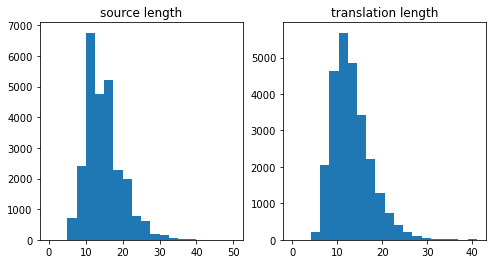

In [9]:
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(map(len, map(str.split, train_inp))), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(map(len, map(str.split, train_out))), bins=20);

### Encoder-decoder model

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
class BasicModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        A simple encoder-decoder seq2seq model
        """
        super().__init__() # initialize base class to track sub-layers, parameters, etc.

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        
        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))
        
    def forward(self, inp, out):
        """ Apply model in training mode """
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)


    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :returns: initial decoder state tensors, one or many
        """
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]
        
        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]
        
        # note: last_state is not _actually_ last because of padding, let's find the real last_state
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]
        
        dec_start = self.dec_start(last_state)
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors, same as returned by encode(...)
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, len(out_voc)]
        """
        prev_gru0_state = prev_state[0]
        
        prev_ix = self.emb_out(prev_tokens)
        output = self.dec0(prev_ix, prev_gru0_state)
        output_logits = self.logits(output)
        new_dec_state = [output]
        
        return new_dec_state, output_logits

    def decode(self, initial_state, out_tokens, **flags):
        """ Iterate over reference tokens (out_tokens) with decode_step """
        batch_size = out_tokens.shape[0]
        state = initial_state
        
        # initial logits: always predict BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)
        
        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version) """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64, 
                              device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)
        
        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states


In [12]:
# debugging area
model = BasicModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

In [13]:
dummy_translations, dummy_states = model.translate_lines(train_inp[:3], max_len=25)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

Translations without training:
stun@@ shop motorcycle silly ballerinas adole@@ life descend arch@@ bly pa@@ swimsuits civil expanse trumpets bite unloading unloading centr@@ tric streetlight tie-@@ surge@@ name@@ wicker
stun@@ bib ations pped ings ford headbands middle-@@ mowing meat daylight o-@@ clams cau@@ people descend arch@@ bly sin@@ butcher traditional spandex traditional ading kitten
leaf placed centr@@ screaming grills mouths blanket elabor@@ traditional out arrow enthusiastically enjoys keeping on@@ section floral stuff@@ deserted trick sting floppy sparkler bea@@ bends


### Training loss (2 points)

Our training objective is almost the same as it was for neural language models:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

where $|D|$ is the __total length of all sequences__, including BOS and first EOS, but excluding PAD.

In [14]:

def compute_loss(model, inp, out, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]
    
    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)
    
    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)

    # log-probabilities of all tokens at all steps, [batch_size, out_len, num_tokens]
    logprobs_seq = F.log_softmax(logits_seq, dim=-1)
   
    # log-probabilities of correct outputs, [batch_size, out_len]
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1)
    # ^-- this will select the probability of the actual next token.
    # Note: you can compute loss more efficiently using using F.cross_entropy

    # average cross-entropy over tokens where mask == True
    return  -1 * torch.mean(logp_out[mask], dtype=torch.float32) # average loss, scalar

In [15]:
F.one_hot(torch.tensor([[1,2,3],[1,2,3]]), 5).size()

torch.Size([2, 3, 5])

In [16]:
dummy_loss = compute_loss(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

Loss: tensor(7.6161, grad_fn=<MulBackward0>)


### Evaluation: BLEU

In [17]:
from nltk.translate.bleu_score import corpus_bleu
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    Estimates corpora-level BLEU score of model's translations given inp and reference out
    Note: if you're serious about reporting your results, use https://pypi.org/project/sacrebleu
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
            ) * 100

In [18]:
compute_bleu(model, dev_inp, dev_out)

0.0020811865623232284

### Training loop

In [19]:
from IPython.display import clear_output
from tqdm import tqdm, trange
metrics = {'train_loss': [], 'dev_bleu': [] }

model = BasicModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

In [20]:
def train(model, opt, nb_epochs, metrics, batch_size):
    for _ in trange(nb_epochs):
        step = len(metrics['train_loss']) + 1
        batch_ix = np.random.randint(len(train_inp), size=batch_size)
        batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
        batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)
    
        loss_t = compute_loss(model, batch_inp, batch_out)
        opt.zero_grad()
        loss_t.backward()
        opt.step()
        
        metrics['train_loss'].append((step, loss_t.item()))
        
        if step % 100 == 0:
            metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))
            
            clear_output(True)
            plt.figure(figsize=(12,4))
            for i, (name, history) in enumerate(sorted(metrics.items())):
                plt.subplot(1, len(metrics), i + 1)
                plt.title(name)
                plt.plot(*zip(*history))
                plt.grid()
            plt.show()
            print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
        
    return metrics

In [ ]:
metrics = train(model, opt, 25000, metrics, batch_size)

In [ ]:
assert np.mean(metrics['dev_bleu'][-10:], axis=0)[1] > 15, "We expect a higher BLEU from you."

In [ ]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

# Attention

### Attention layer (3 points)

In [21]:
class AttentionLayer(nn.Module):
    def __init__(self, name, enc_size, dec_size, hid_size, activ=torch.tanh):
        """ A layer that computes additive attention response and weights """
        super().__init__()
        self.name = name
        self.enc_size = enc_size # num units in encoder state
        self.dec_size = dec_size # num units in decoder state
        self.hid_size = hid_size # attention layer hidden units
        self.activ = activ       # attention layer hidden nonlinearity
        
        # create trainable paramteres like this:
        #self.<PARAMETER_NAME> = nn.Parameter(<INITIAL_VALUES>, requires_grad=True)
        self.linear_enc = nn.Linear(enc_size, hid_size)
        self.linear_dec = nn.Linear(dec_size, hid_size)
        self.linear_out = nn.Linear(hid_size, 1)
        

    def forward(self, enc, dec, inp_mask):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size]
        :param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
        """

        # Compute logits
        lin_enc = self.linear_enc(enc)
        lin_dec = self.linear_dec(dec).unsqueeze(1).repeat([1, enc.size(1), 1])
        logits = self.linear_out(self.activ(lin_enc + lin_dec)).squeeze(-1)

        # Apply mask - if mask is 0, logits should be -inf or -1e9
        # You may need torch.where
        neg_inf = torch.full_like(logits, float('-inf'))
        logits_masked = torch.where(inp_mask != 0, logits, neg_inf)

        # Compute attention probabilities (softmax)
        probs = F.softmax(logits_masked, dim=1)

        # Compute attention response using enc and probs
        attn = torch.sum(enc * probs.unsqueeze(2), dim=1)

        return attn, probs

### Seq2seq model with attention (3 points)

In [22]:
class AttentiveModel(BasicModel):
    def __init__(self, name, inp_voc, out_voc,
                 emb_size=64, hid_size=128, attn_size=128):
        """ Translation model that uses attention. See instructions above. """
        nn.Module.__init__(self)  # initialize base class to track sub-layers, trainable variables, etc.
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        
        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.attention = AttentionLayer('attention', hid_size, hid_size, attn_size)
        self.logits = nn.Linear(2*hid_size, len(out_voc))

    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        
        # encode input sequence, create initial decoder states
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]
        
        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]
        
        # note: last_state is not _actually_ last because of padding, let's find the real last_state
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]
        
        dec_start = self.dec_start(last_state)
        
        # apply attention layer from initial decoder hidden state
        mask = self.inp_voc.compute_mask(inp)
        _, first_attn_probas = self.attention(enc_seq, dec_start, mask)
        
        # Build first state: include
        # * initial states for decoder recurrent layers
        # * encoder sequence and encoder attn mask (for attention)
        # * make sure that last state item is attention probabilities tensor
        
        first_state = [dec_start, enc_seq, mask, first_attn_probas]
        return first_state
   
    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """
        
        prev_gru0_state = prev_state[0]
        enc_seq = prev_state[1]
        mask = prev_state[2]
        
        prev_ix = self.emb_out(prev_tokens)
        output = self.dec0(prev_ix, prev_gru0_state)
        attn, probas = self.attention(enc_seq, output, mask)
        output_attn = torch.cat((output, attn), dim=1)
        output_logits = self.logits(output_attn)

        new_dec_state = [output, enc_seq, mask, probas]
        return new_dec_state, output_logits


### Training attentive model

In [ ]:
from IPython.display import clear_output
from tqdm import tqdm, trange
metrics = {'train_loss': [], 'dev_bleu': [] }

model = AttentiveModel('en_fr', inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

In [ ]:
metrics = train(model, opt, 10000, metrics, batch_size)

In [ ]:
print("BLEU:", np.mean(metrics['dev_bleu'][-10:], axis=0)[1])

In [ ]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

### Visualizing model attention

In [23]:
import bokeh.plotting as pl
import bokeh.models as bm
from bokeh.io import output_notebook, show
output_notebook()

def draw_attention(inp_line, translation, probs):
    """ An intentionally ambiguous function to visualize attention weights """
    inp_tokens = inp_voc.tokenize(inp_line)
    trans_tokens = out_voc.tokenize(translation)
    probs = probs[:len(trans_tokens), :len(inp_tokens)]
    
    fig = pl.figure(x_range=(0, len(inp_tokens)), y_range=(0, len(trans_tokens)),
                    x_axis_type=None, y_axis_type=None, tools=[])
    fig.image([probs[::-1]], 0, 0, len(inp_tokens), len(trans_tokens))

    fig.add_layout(bm.LinearAxis(axis_label='source tokens'), 'above')
    fig.xaxis.ticker = np.arange(len(inp_tokens)) + 0.5
    fig.xaxis.major_label_overrides = dict(zip(np.arange(len(inp_tokens)) + 0.5, inp_tokens))
    fig.xaxis.major_label_orientation = 45

    fig.add_layout(bm.LinearAxis(axis_label='translation tokens'), 'left')
    fig.yaxis.ticker = np.arange(len(trans_tokens)) + 0.5
    fig.yaxis.major_label_overrides = dict(zip(np.arange(len(trans_tokens)) + 0.5, trans_tokens[::-1]))

    show(fig)

ModuleNotFoundError: No module named 'bokeh'

In [ ]:
inp = dev_inp[::500]

trans, states = model.translate_lines(inp)

# select attention probs from model state (you may need to change this for your custom model)
# attention_probs below must have shape [batch_size, translation_length, input_length], extracted from states
# e.g. if attention probs are at the end of each state, use np.stack([state[-1] for state in states], axis=1)
attention_probs = np.stack([state[-1].cpu().detach() for state in states], axis=1)

In [ ]:
for i in range(5):
    draw_attention(inp[i], trans[i], attention_probs[i])
    

## Goind deeper (2++ points each)

In [56]:
class EnhancedModel(AttentiveModel):
    def __init__(self, name, inp_voc, out_voc,
                 emb_size=64, hid_size=128, attn_size=128):
        """ Translation model that uses attention. See instructions above. """
        super().__init__(name, inp_voc, out_voc, emb_size, hid_size, attn_size) 

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version) """
        beam_size = 1
        if "beam_size" in flags:
            beam_size = flags["beam_size"]
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = [initial_state[0]] * beam_size
        beams = torch.zeros([batch_size, beam_size, max_len], dtype=torch.int64, device=device)

        new_words = torch.full([batch_size, beam_size], self.out_voc.bos_ix, dtype=torch.int64, device=device)
        logits = torch.zeros([batch_size, beam_size, len(out_voc)], dtype=torch.float32, device=device)
        eos_logits = torch.zeros([batch_size, beam_size], dtype=torch.float32, device=device)
        for i in range(max_len):
            for j in range(beam_size):
                tmp_state = [state[j]] + initial_state[1:]
                tmp_state, logits[:,j,:] = self.decode_step(tmp_state, new_words[:,j])
                state[j] = tmp_state[0]
            max_logits = logits.max(dim=1) # all beams combined
            new_words = max_logits.values.topk(beam_size, dim=-1).indices # beam_size new words

            # save eos logits
            eos_indexes = new_words == out_voc.eos_ix
            eos_logits[eos_indexes] = logits[:,:,out_voc.eos_ix][eos_indexes]

            # change beam order according to new_words choice
            from_beams = torch.gather(max_logits.indices, 1, new_words) # to which sentences these words belong
            # ^-- shape: [batch_size, beam_size]
            for j in range(batch_size):
                for k in range(beam_size):
                    state[k][j] = state[from_beams[j,k]][j]
            from_beams = from_beams.unsqueeze(2).repeat(1,1,max_len)
            beams = torch.gather(beams, 1, from_beams)

            # add new words
            beams[:, :, i] = new_words
        
        indexes = eos_logits.argmax(dim=1)
        indexes = indexes.unsqueeze(1).unsqueeze(2).repeat(1, beam_size, max_len)
        out = torch.gather(beams, 1, indexes)[:,0,:]
        
        return out, state


In [59]:
model = EnhancedModel('en_fr', inp_voc, out_voc).to(device)
dummy_translations, dummy_states = model.translate_lines(train_inp[:3], max_len=25, beam_size=10)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

Translations without training:
mouse women pretty pretty pretty pretty helps hamburgers insec@@ pretty pretty por@@ notebooks after@@ leans leans case leans business rou@@ gowns gowns gowns gowns gowns
pad ckled ckled ckled ckled butt@@ america ckled america ken@@ wallet ically can seattle pri@@ pri@@ re-@@ re-@@ re-@@ re-@@ re-@@ re-@@ re-@@ re-@@ nati@@
able ckled ckled environment environment environment environment environment environment environment environment environment environment environment environment environment environment environment environment environment environment environment environment environment rese@@


In [60]:
from IPython.display import clear_output
from tqdm import tqdm, trange
metrics = {'train_loss': [], 'dev_bleu': [] }

model = EnhancedModel('en_fr', inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

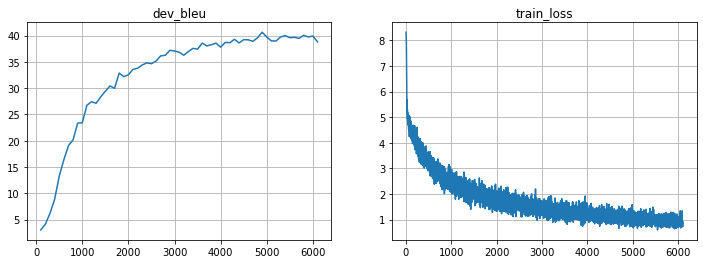

Mean loss=0.846


 62%|███████████████████████████████████████████████████████████████████████████▋                                              | 6199/10000 [2:12:16<1:21:06,  1.28s/it]


KeyboardInterrupt: 

In [61]:
metrics = train(model, opt, 10000, metrics, batch_size)

In [62]:
print("BLEU:", np.mean(metrics['dev_bleu'][-10:], axis=0)[1])

BLEU: 39.59732177760053


In [66]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500],beam_size=2)[0]):
    print(inp_line)
    print(trans_line)
    print()

un petit garçon tirant une remorque verte vêtu d&apos; un sweat-shirt et de bottes .
a little boy pulling a motorcycle wearing a sweatshirt while wearing boots .

deux filles portant des bonnets courent dans des am@@ as de neige dehors .
the two girls wearing hats are running through a snow covered snow . outside .

une jeune personne colorie et dessine sur le trottoir avec une craie rose .
a girl is smiling while on the curb with a bright green light .

une voiture de course passe à toute vitesse sur le circuit .
a race race is running on the racetrack .

un homme fait fonctionner une machine tandis qu&apos; il travaille dans une usine .
a man is operating a machine as he works into a factory .

une femme orientale travaillant sur une chaîne de prod@@ u@@ ction .
an old oriental woman working on an electric furniture . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 